In [1]:
# this code analyses and predicts the chiller performance ['total_kW'] based on ['amb_temp','run_sts','vsd_freq']
# results are not accurate unless a cload_group was created which vastly improve the accuracy of the model

In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pymssql
# import pyodbc  as pdc
import sqlalchemy as sa
import os

import urllib.parse

import re
import tqdm

import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
# Get the password from the environment variable
password = os.getenv('SQL_PASSWORD')

database='master'
encoded_password = urllib.parse.quote_plus(password)

q='SELECT Timestamp,[VALUE] as amb_temp FROM [niagara].[dbo].R320_2_CH1_AMB_TEMP'
# engine = pdc.connect(f'mssql+pymssql://{username}:{encoded_password}@{server}/master')
# engine = sa.create_engine(f'mssql+pymssql://{username}:{encoded_password}@{server}/master')
# # engine = sa.create_engine(f'mssql+pymssql://{username}:{password}@{server}/master')
# cnxn = pdc.connect('DRIVER={ODBC Driver 18 for SQL Server};SERVER='+server+';DATABASE='+database+';ENCRYPT=yes;UID='+username+';PWD='+ password)
# cursor = cnxn.cursor()
# pd.read_sql(q,engine)

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)



In [6]:
df=pd.read_csv('../SQLMasterMetaData2.csv').drop(['Unnamed: 0'],axis=1)
df[df['TABLE_NAME'].str.contains('R320')].TABLE_NAME.values

ch_parms=['R320_2_CH1_AMB_TEMP','R320_1_CH1_RUN_STS','R320_2_CH1_VSD_OUTFREQ','R320_2_CH1_METER_TOTAL_ACTIVE_POWER'] 
# order is important to match labels 
labels=['amb_temp','run_sts','vsd_freq','total_kW']



In [7]:
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
        # point=rtus[3]
        query1=f"""SELECT 
                Timestamp,[VALUE] as {labels[i]}
                FROM [niagara].[dbo].{point}"""
        # print(query1)
        # cursor.execute(query1)
        # tempdf=pd.DataFrame(cursor.fetchall())
        tempdf=pd.read_sql(query1,conn)
        if len(tempdf)<10000:
            print(point,'==> IGNORED!!!')
            ignored.append(point)
            continue
        tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
        res=res.join(tempdf,how='outer')
res['run_sts']=res.run_sts.fillna(method='ffill')
res['run_sts']=res.run_sts.fillna(method='bfill')

res


KeyboardInterrupt: 

In [22]:
res.run_sts.describe()

count    133230.000000
mean          0.706693
std           0.441484
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: run_sts, dtype: float64

<AxesSubplot: ylabel='Count'>

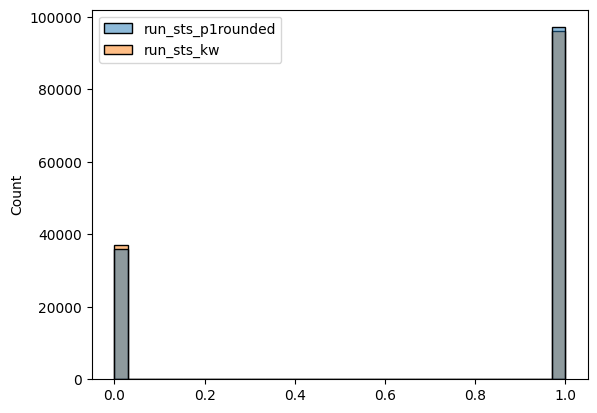

In [5]:
# which method of approximation is the most accurate
dd=res.copy()
dd['run_sts_rounded']=dd['run_sts'].round()
dd['run_sts_p1rounded']=(dd['run_sts']+.1).round()
dd=dd[~dd['total_kW'].isna()]
dd['run_sts_kw']=dd.total_kW.apply(lambda x: 1 if x>10 else 0)

runs=[i for i in dd.columns if 'run' in i.lower()]
runs=[ 'run_sts_p1rounded', 'run_sts_kw']
sns.histplot(dd[runs])
# dd

# most accurate results is run_sts_p1rounded



In [6]:
res=res[~res['total_kW'].isna()]
res['run_sts_rounded']=(res['run_sts']+.1).round() # same as run_sts_p1rounded
res.groupby('run_sts_rounded').mean()


,amb_temp,run_sts,vsd_freq,total_kW
run_sts_rounded,,,,
0.0,22.231171,0.002962,2.939089,2.914073
1.0,30.969322,0.967989,95.154263,77.105702


In [7]:
rr=res[res['run_sts_rounded']==1] # res while running
rr=rr.drop(['run_sts','run_sts_rounded'],axis=1)
# rr.corr()
rr['cool_load']=rr.vsd_freq/185
rr['pcnt_load']=rr.total_kW/235.74
rr=rr.reset_index()
rr=rr[rr.total_kW>10]
# rr.drop(['Timestamp','vsd_freq','total_kW'],axis=1,inplace=True)
rr=rr[rr.amb_temp>=20]
rr=rr[rr.cool_load>=0.25]
rr


,Timestamp,amb_temp,vsd_freq,total_kW,cool_load,pcnt_load
186,2019-09-19 14:15:00,41.33,131.5,143.12,0.710811,0.607110
187,2019-09-19 14:30:00,41.67,131.2,144.60,0.709189,0.613388
188,2019-09-19 14:45:00,40.89,135.4,146.74,0.731892,0.622465
189,2019-09-19 15:00:00,41.00,138.5,151.67,0.748649,0.643378
190,2019-09-19 15:15:00,40.00,138.2,151.26,0.747027,0.641639
...,...,...,...,...,...,...
97151,2023-08-10 00:15:00,35.90,105.0,106.25,0.567568,0.450708
97152,2023-08-10 00:30:00,35.78,100.0,98.60,0.540541,0.418257
97153,2023-08-10 00:45:00,35.83,100.6,98.10,0.543784,0.416136
97154,2023-08-10 01:00:00,36.06,104.2,96.25,0.563243,0.408289


<AxesSubplot: xlabel='amb_temp', ylabel='cool_load'>

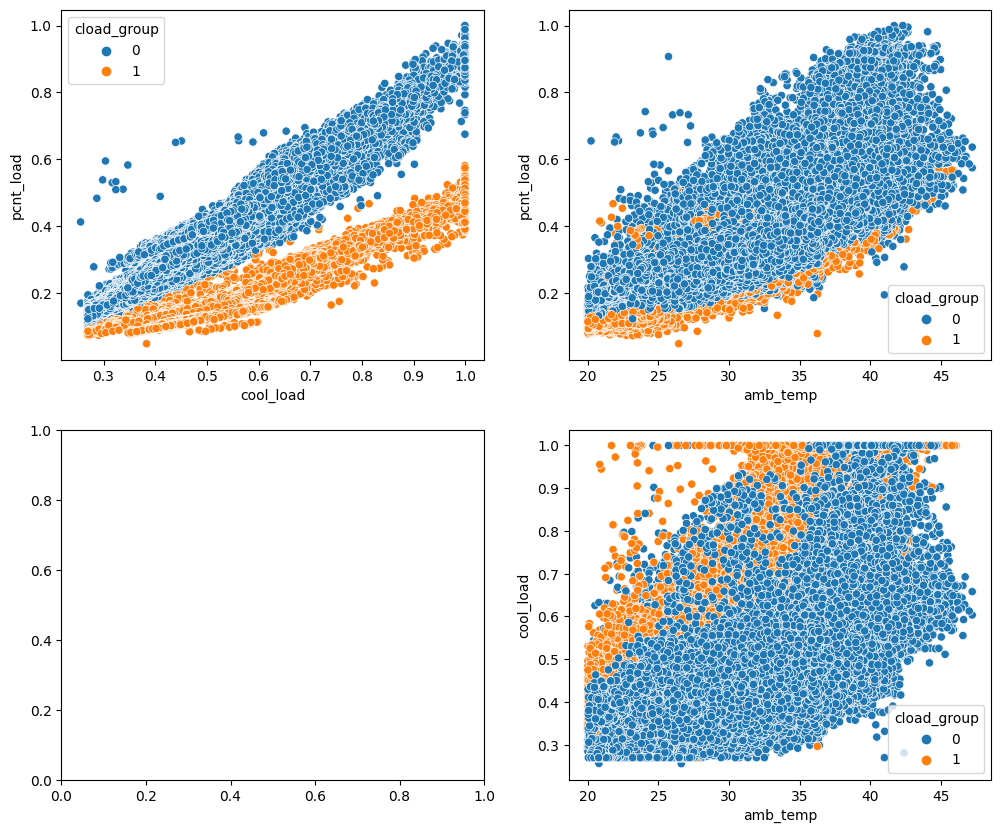

In [8]:
rr['cload_group']=rr.apply(lambda x: 0 if x.cool_load*.7-.1<x.pcnt_load else 1,axis=1)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x=rr.cool_load,y=rr.pcnt_load,ax=ax1,hue=rr.cload_group)
sns.scatterplot(x=rr.amb_temp,y=rr.pcnt_load,ax=ax2,hue=rr.cload_group)
sns.scatterplot(x=rr.amb_temp,y=rr.cool_load,ax=ax4,hue=rr.cload_group)




<AxesSubplot: xlabel='month', ylabel='Count'>

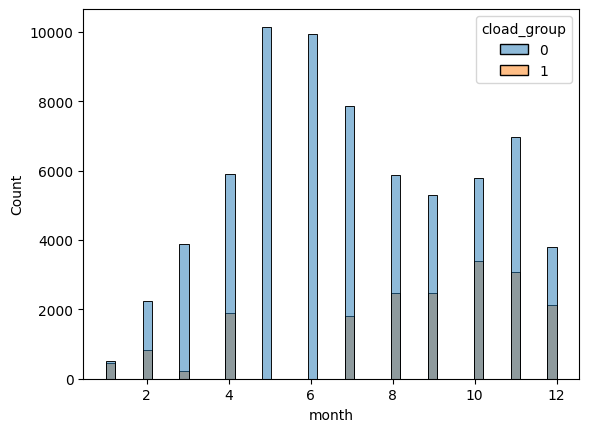

In [9]:
rr['month']= rr.Timestamp.dt.month
# sns.lineplot(rr.month,hue=rr.cload_group)
sns.histplot(x=rr.month,hue=rr.cload_group)
# rr.cload_group.value_counts()

### Training the Model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold,train_test_split
from sklearn.impute import SimpleImputer
X=rr[['cool_load','amb_temp','cload_group']]
y=rr.pcnt_load
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    # ('Scaler',StandardScaler()),
    ('model',RandomForestRegressor())
    
    ])
model_.fit(X_train,y_train)


X=rr[['cool_load','amb_temp']]
y=rr.pcnt_load
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, random_state=42)
model_0=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    # ('Scaler',StandardScaler()),
    ('model',RandomForestRegressor())
    
    ])
model_0.fit(X_train0,y_train0)


# cross_val_score(model_,X,y,cv=k_fold, scoring='r2')

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model', RandomForestRegressor())])

In [18]:
# model_.predict(X_test)
import numpy as np
tt1=X_test.copy() # with cload group
tt1['pred']=model_.predict(X_test)
tt1['truth']=y_test
tt1['error']=tt1.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)
print('with cload group\nError:',np.round(abs(tt1.error).mean(),3))

tt2=X_test0.copy() # without cload group
tt2['pred']=model_0.predict(X_test0)
tt2['truth']=y_test
tt2['error']=tt2.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)
print('without cload group\nError:',np.round(abs(tt2.error).mean(),3))
tt2['cload_group']=tt1.cload_group


with cload group
Error: 0.026
without cload group
Error: 0.115


Text(0.5, 1.0, 'with c_load group')

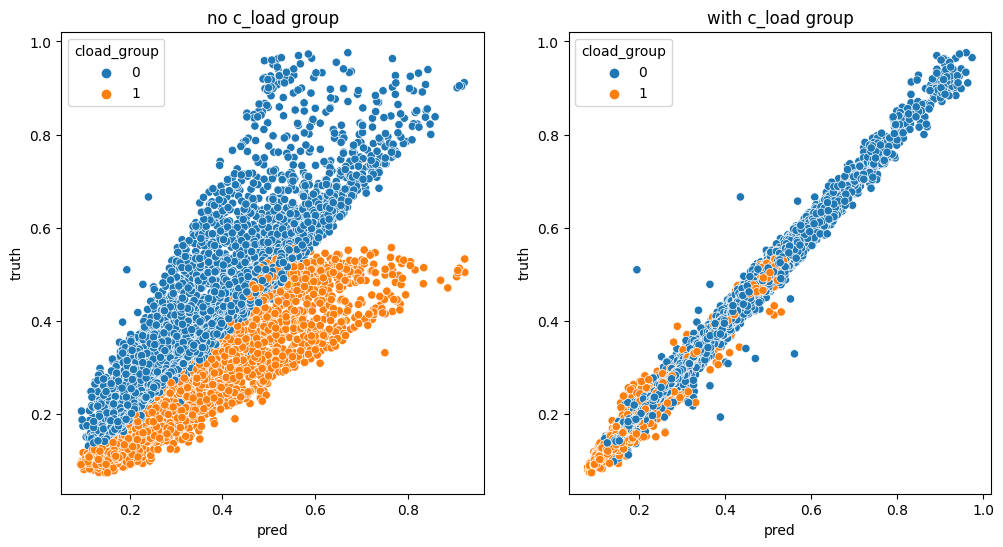

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[12,6])
sns.scatterplot(x=tt2.pred,y=tt2.truth,ax=ax1,hue=tt2.cload_group)
ax1.set_title('no c_load group')
sns.scatterplot(x=tt1.pred,y=tt1.truth,ax=ax2,hue=tt1.cload_group)
ax2.set_title('with c_load group')